# Render a 4D textured mesh

This tutorial shows how to:
- load a mesh and textures from an `.obj` file. 
- set up a renderer 
- render the mesh 
- vary the rendering settings such as lighting and camera position
- use the batching features of the pytorch3d API to render the mesh from different viewpoints

## 0. Install and Import modules

In [1]:
import os
import sys

import matplotlib.pyplot as plt
import pytorch3d
import torch

from pytorch3d.io import load_objs_as_meshes, load_obj
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras, 
    DirectionalLights, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    TexturesUV,
    TexturesVertex
)
from pytorch3d.structures import Meshes
from pytorch3d.vis.plotly_vis import (
    AxisArgs,
    plot_batch_individually,
    plot_scene
)
from pytorch3d.vis.texture_vis import texturesuv_image_matplotlib


# Overridden classes for 4D texture rendering
from plenoptic_pytorch.blending import SoftPhongShader
from plenoptic_pytorch.lighting import PointLights
from plenoptic_pytorch.materials import Materials
from utils.plot_image_grid import image_grid


sys.path.append(os.path.abspath(''))

### 1. Load a mesh and texture file

Load an `.obj` file and its associated `.mtl` file and create a **Textures** and **Meshes** object. 

**Meshes** is a unique datastructure provided in PyTorch3D for working with batches of meshes of different sizes. 

**TexturesUV** is an auxiliary datastructure for storing vertex uv and texture maps for meshes. 

**Meshes** has several class methods which are used throughout the rendering pipeline.

In [2]:
# Setup
device = torch.device("cpu")

# Set paths
DATA_DIR = "./data"
obj_filename = os.path.join(DATA_DIR, "cow_mesh/cow.obj")

# Load obj file
mesh = load_objs_as_meshes([obj_filename], device=device)


# @ellin Add additional dim to texture.
# Can be a repeat of an RGB channel or programmatically determined.
# ir_texture = torch.unsqueeze(mesh.textures._maps_padded[:,:,:,2], dim=-1)
ir_texture = torch.ones(mesh.textures._maps_padded.size()[:-1] + (1,))
mesh.textures._maps_padded = torch.cat(
    (mesh.textures._maps_padded, ir_texture),
    dim=-1,
)

#### Let's visualize the texture map

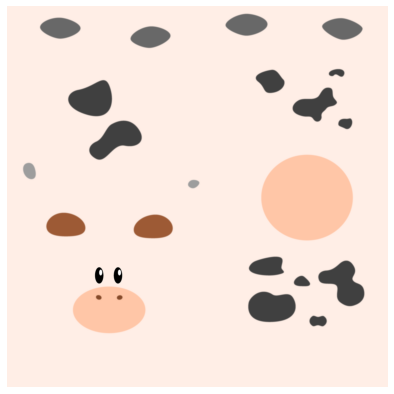

In [3]:
plt.figure(figsize=(7,7))
texture_image = mesh.textures.maps_padded()
plt.imshow(texture_image.squeeze().cpu().numpy()[...,:3])
plt.axis("off");

PyTorch3D has a built-in way to view the texture map with matplotlib along with the points on the map corresponding to vertices. There is also a method, texturesuv_image_PIL, to get a similar image which can be saved to a file.

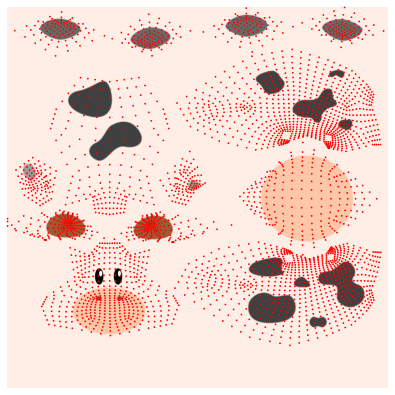

In [4]:
plt.figure(figsize=(7,7))
texturesuv_image_matplotlib(mesh.textures, subsample=None)
plt.axis("off");

## 2. Create a renderer

A renderer in PyTorch3D is composed of a **rasterizer** and a **shader** which each have a number of subcomponents such as a **camera** (orthographic/perspective). Here we initialize some of these components and use default values for the rest.

In this example we will first create a **renderer** which uses a **perspective camera**, a **point light** and applies **Phong shading**. Then we learn how to vary different components using the modular API.  

In [5]:
# Initialize a camera.
# With world coordinates +Y up, +X left and +Z in, the front of the cow is facing the -Z direction. 
# So we move the camera by 180 in the azimuth direction so it is facing the front of the cow. 
R, T = look_at_view_transform(2.7, 0, 180) 
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

# Define the settings for rasterization and shading. Here we set the output image to be of size
# 512x512. As we are rendering images for visualization purposes only we will set faces_per_pixel=1
# and blur_radius=0.0. We also set bin_size and max_faces_per_bin to None which ensure that 
# the faster coarse-to-fine rasterization method is used. Refer to rasterize_meshes.py for 
# explanations of these parameters. Refer to docs/notes/renderer.md for an explanation of 
# the difference between naive and coarse-to-fine rasterization. 
raster_settings = RasterizationSettings(
    image_size=512, 
    blur_radius=0.0, 
    faces_per_pixel=1, 
)

# Place a point light in front of the object. As mentioned above, the front of the cow is facing the 
# -z direction. 
lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])

# Create a Phong renderer by composing a rasterizer and a shader. The textured Phong shader will 
# interpolate the texture uv coordinates for each vertex, sample from a texture image and 
# apply the Phong lighting model
renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=SoftPhongShader(
        device=device, 
        cameras=cameras,
        lights=lights
    )
)

## 3. Move the light behind the object and re-render

We can pass arbitrary keyword arguments to the `rasterizer`/`shader` via the call to the `renderer` so the renderer does not need to be reinitialized if any of the settings change/

In this case, we can simply update the location of the lights and pass them into the call to the renderer. 

The image is now dark as there is only ambient lighting, and there are no specular highlights.

In [6]:
# Now move the light so it is on the +Z axis which will be behind the cow. 
lights.location = torch.tensor([0.0, 0.0, +1.0], device=device)[None]
images = renderer(mesh, lights=lights)

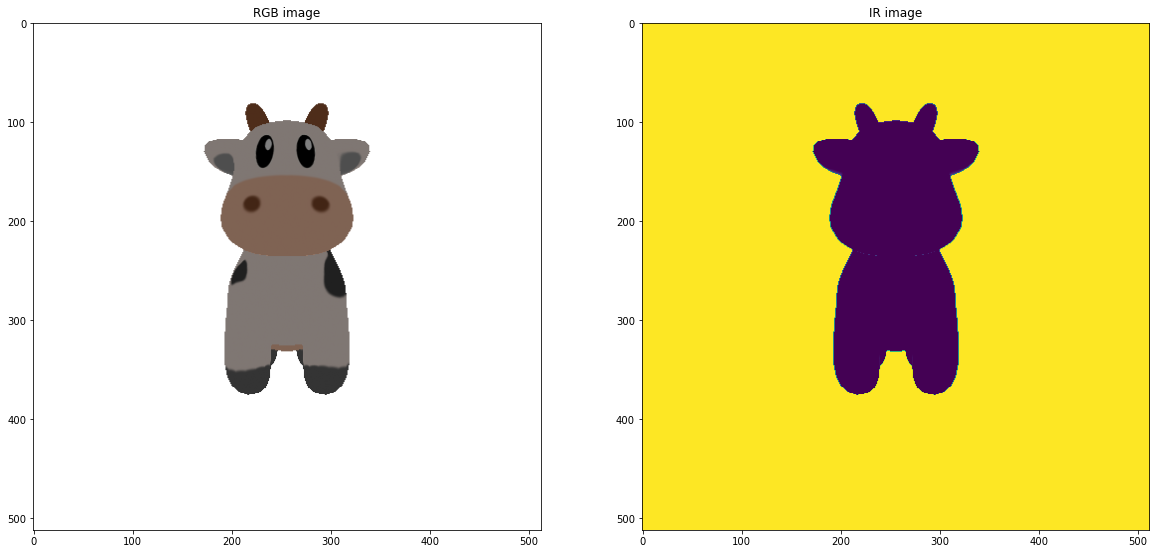

In [7]:
plt.figure(figsize=(20, 10))

plt.subplot(121)
plt.title('RGB image')
plt.imshow(images[0, ..., :3].cpu().numpy())

plt.subplot(122)
plt.title('IR image')
plt.imshow(images[0, ..., 3].cpu().numpy())

## 5. Rotate the object, modify the material properties or light properties

We can also change many other settings in the rendering pipeline. Here we:

- change the **viewing angle** of the camera
- change the **position** of the point light
- change the **material reflectance** properties of the mesh

In [8]:
# Rotate the object by increasing the elevation and azimuth angles
R, T = look_at_view_transform(dist=2.7, elev=10, azim=-150)
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

# Move the light location so the light is shining on the cow's face.  
lights.location = torch.tensor([[2.0, 2.0, -2.0]], device=device)

# Change specular color to green and change material shininess 
materials = Materials(
    device=device,
    specular_color=[[0.0, 1.0, 0.0, 1.0]],
    shininess=10.0
)

# Re render the mesh, passing in keyword arguments for the modified components.
images = renderer(mesh, lights=lights, materials=materials, cameras=cameras)

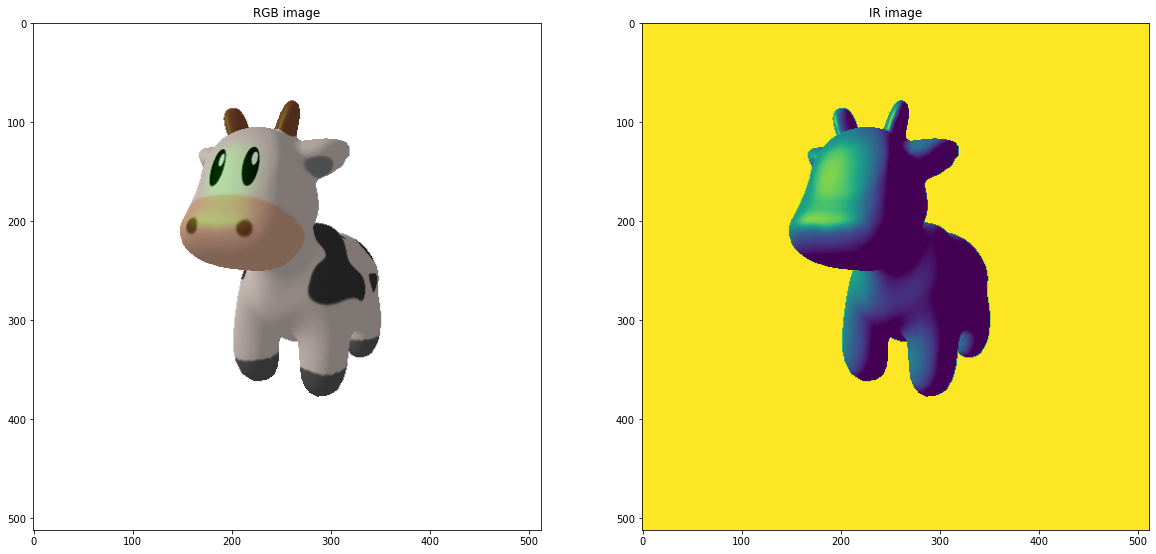

In [9]:
plt.figure(figsize=(20, 10))

plt.subplot(121)
plt.title('RGB image')
plt.imshow(images[0, ..., :3].cpu().numpy())

plt.subplot(122)
plt.title('IR image')
plt.imshow(images[0, ..., 3].cpu().numpy())

## 6. Batched Rendering

One of the core design choices of the PyTorch3D API is to support **batched inputs for all components**. 
The renderer and associated components can take batched inputs and **render a batch of output images in one forward pass**. We will now use this feature to render the mesh from many different viewpoints.


In [ ]:
# Set batch size - this is the number of different viewpoints from which we want to render the mesh.
batch_size = 20

# Create a batch of meshes by repeating the cow mesh and associated textures. 
# Meshes has a useful `extend` method which allows us do this very easily. 
# This also extends the textures. 
meshes = mesh.extend(batch_size)

# Get a batch of viewing angles. 
elev = torch.linspace(0, 180, batch_size)
azim = torch.linspace(-180, 180, batch_size)

# All the cameras helper methods support mixed type inputs and broadcasting. So we can 
# view the camera from the same distance and specify dist=2.7 as a float,
# and then specify elevation and azimuth angles for each viewpoint as tensors. 
R, T = look_at_view_transform(dist=2.7, elev=elev, azim=azim)
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

# Move the light back in front of the cow which is facing the -z direction.
lights.location = torch.tensor([[0.0, 0.0, -3.0]], device=device)

In [ ]:
# We can pass arbitrary keyword arguments to the rasterizer/shader via the renderer
# so the renderer does not need to be reinitialized if any of the settings change.
images = renderer(meshes, cameras=cameras, lights=lights)

In [ ]:
image_grid(images.cpu().numpy(), rows=4, cols=5, rgb=True)

## 7. Plotly visualization 
If you only want to visualize a mesh, you don't really need to use a differentiable renderer - instead we support plotting of Meshes with plotly. For these Meshes, we use TexturesVertex to define a texture for the rendering.
`plot_meshes` creates a Plotly figure with a trace for each Meshes object. 

In [ ]:
verts, faces_idx, _ = load_obj(obj_filename)
faces = faces_idx.verts_idx

# Initialize each vertex to be white in color.
verts_rgb = torch.ones_like(verts)[None]  # (1, V, 3)
textures = TexturesVertex(verts_features=verts_rgb.to(device))

# Create a Meshes object
mesh = Meshes(
    verts=[verts.to(device)],   
    faces=[faces.to(device)],
    textures=textures
)

# Render the plotly figure
fig = plot_scene({
    "subplot1": {
        "cow_mesh": mesh
    }
})
fig.show()

In [ ]:
# use Plotly's default colors (no texture)
mesh = Meshes(
    verts=[verts.to(device)],   
    faces=[faces.to(device)]
)

# Render the plotly figure
fig = plot_scene({
    "subplot1": {
        "cow_mesh": mesh
    }
})
fig.show()

In [ ]:
# create a batch of meshes, and offset one to prevent overlap
mesh_batch = Meshes(
    verts=[verts.to(device), (verts + 2).to(device)],   
    faces=[faces.to(device), faces.to(device)]
)

# plot mesh batch in the same trace
fig = plot_scene({
    "subplot1": {
        "cow_mesh_batch": mesh_batch
    }
})
fig.show()

In [ ]:
# plot batch of meshes in different traces
fig = plot_scene({
    "subplot1": {
        "cow_mesh1": mesh_batch[0],
        "cow_mesh2": mesh_batch[1]
    }
})
fig.show()

In [ ]:
# plot batch of meshes in different subplots
fig = plot_scene({
    "subplot1": {
        "cow_mesh1": mesh_batch[0]
    },
    "subplot2":{
        "cow_mesh2": mesh_batch[1]
    }
})
fig.show()

For batches, we can also use `plot_batch_individually` to avoid constructing the scene dictionary ourselves.

In [ ]:
# extend the batch to have 4 meshes
mesh_4 = mesh_batch.extend(2)

# visualize the batch in different subplots, 2 per row
fig = plot_batch_individually(mesh_4)
# we can update the figure height and width
fig.update_layout(height=1000, width=500)
fig.show()

We can also modify the axis arguments and axis backgrounds in both functions. 

In [ ]:
fig2 = plot_scene({
    "cow_plot1": {
        "cows": mesh_batch
    }
},
    xaxis={"backgroundcolor":"rgb(200, 200, 230)"},
    yaxis={"backgroundcolor":"rgb(230, 200, 200)"},
    zaxis={"backgroundcolor":"rgb(200, 230, 200)"}, 
    axis_args=AxisArgs(showgrid=True))
fig2.show()

In [ ]:
fig3 = plot_batch_individually(
    mesh_4, 
    ncols=2,
    subplot_titles = ["cow1", "cow2", "cow3", "cow4"], # customize subplot titles
    xaxis={"backgroundcolor":"rgb(200, 200, 230)"},
    yaxis={"backgroundcolor":"rgb(230, 200, 200)"},
    zaxis={"backgroundcolor":"rgb(200, 230, 200)"}, 
    axis_args=AxisArgs(showgrid=True))
fig3.show()

## 8. Conclusion
In this tutorial we learnt how to **load** a textured mesh from an obj file, initialize a PyTorch3D datastructure called **Meshes**, set up an **Renderer** consisting of a **Rasterizer** and a **Shader**, and modify several components of the rendering pipeline. We also learned how to render Meshes in Plotly figures.